In [1]:
!pip install ../mtl_code

Processing /Users/pierre-antoine/Desktop/inria_bilevel_optim/mtl_code
  Created wheel for mtl: filename=mtl-0.0.0-cp37-none-any.whl size=5359 sha256=46e55ff9564e979103aa5349f0e9c7d6ea487261dff311c4ec58bb9dff4d47eb
  Stored in directory: /private/var/folders/88/1nv03x2s1mv2xlv78myb8nnc0000gn/T/pip-ephem-wheel-cache-kgip_4n8/wheels/47/64/79/3da8c850f6210d2d028b32e5bf63ff67613b14e3c2a7444888
Successfully built mtl
  Found existing installation: mtl 0.0.0
    Uninstalling mtl-0.0.0:
      Successfully uninstalled mtl-0.0.0


In [2]:
from mtl.simulated_data import simulate_data
from mtl.mtl import ReweightedMTL

import numpy as np
from numpy.linalg import norm

import matplotlib.pyplot as plt
import seaborn as sns

## A first example: sparse signal reconstruction 

First, let's generate some toy data with the **simulate_data** function and plot the coefficient matrix **W**.

In [3]:
X, Y, W =  simulate_data(
    n_samples=8, n_features=10, n_tasks=5, nnz=2, snr=2
)

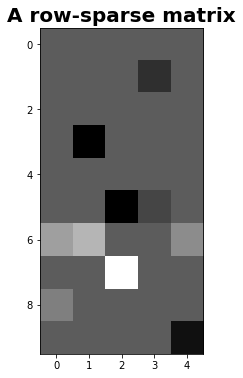

In [4]:
fig = plt.figure(figsize=(8, 6))
plt.title('A row-sparse matrix', fontweight="bold", fontsize=20)
plt.imshow(W, cmap="binary");

Indeed, we see that only one coefficient in each row is non-zero. We will try to reconstruct this matrix from the matrices $X$ and $Y$ using a reweighted $l_1$ minimization.
<br/>
<br/>
Let's compute the maximum value of our regularizer. Recall that $\alpha_{\text{max}} = \frac{1}{n}\lvert\lvert X^{\top}y \rvert\rvert_{\infty}$.

In [5]:
def compute_lambda_max(X, Y):
    return np.max(X.T @ Y) / X.shape[0]

In [6]:
lambda_max = compute_lambda_max(X, Y)
print('Lambda max:', lambda_max)

Lambda max: 3.3489725000144457


In [7]:
regressor = ReweightedMTL(alpha=0.5)
regressor.fit(X, Y)

Iteration 0: 5.6310
Iteration 1: 5.3293
Iteration 2: 5.2166
Iteration 3: 5.2132
Iteration 4: 5.2126


We observe that the training loss has decreased. Let's now compare the recovered signal with the true signal.

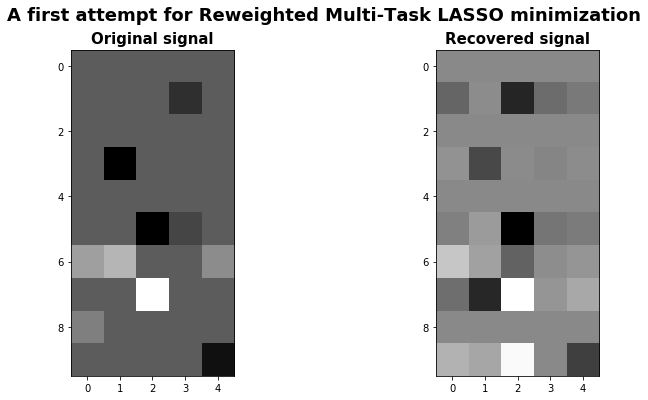

In [8]:
W_hat = regressor.weights

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_title('Original signal', fontweight="bold", fontsize=15)
axes[0].imshow(W, cmap="binary")

axes[1].set_title('Recovered signal', fontweight="bold", fontsize=15)
axes[1].imshow(W_hat, cmap="binary")

fig.suptitle('A first attempt for Reweighted Multi-Task LASSO minimization', fontweight="bold", fontsize=18);

Clearly the sparsity-inducing penalty is not correctly set. We need to find the right  $\lambda$ by CV. For this, let's use the MultiTaskLassoCV.

We define a range for $\alpha$ that does not go beyond $\alpha_{\text{max}}$ since we know that above that value all coefficients are zero.

In [9]:
from mtl.cross_validation import MultiTaskLassoCV

In [10]:
ranges = [
    [x * 10 ** (- i) for x in range(1, 10)] for i in range(0, 4)
]

alpha_range = [x for sublist in ranges for x in sublist]

In [11]:
regressor = MultiTaskLassoCV(alpha_range, n_folds=2)

In [12]:
regressor.fit(X, Y)

Fitting MTL estimator with alpha = 1
Criterion reduced from inf to 5.98144 for alpha = 1
Fitting MTL estimator with alpha = 2
Fitting MTL estimator with alpha = 3
Fitting MTL estimator with alpha = 4
Fitting MTL estimator with alpha = 5
Fitting MTL estimator with alpha = 6
Fitting MTL estimator with alpha = 7
Fitting MTL estimator with alpha = 8
Fitting MTL estimator with alpha = 9
Fitting MTL estimator with alpha = 0.1
Fitting MTL estimator with alpha = 0.2
Fitting MTL estimator with alpha = 0.30000000000000004
Fitting MTL estimator with alpha = 0.4
Fitting MTL estimator with alpha = 0.5
Fitting MTL estimator with alpha = 0.6000000000000001
Fitting MTL estimator with alpha = 0.7000000000000001
Fitting MTL estimator with alpha = 0.8
Fitting MTL estimator with alpha = 0.9
Fitting MTL estimator with alpha = 0.01
Fitting MTL estimator with alpha = 0.02
Fitting MTL estimator with alpha = 0.03
Fitting MTL estimator with alpha = 0.04
Fitting MTL estimator with alpha = 0.05
Fitting MTL estima

/Users/pierre-antoine/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1953: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02974356479309502, tolerance: 0.018662063450908258
  check_random_state(self.random_state), random)
/Users/pierre-antoine/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1953: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028590632065732667, tolerance: 0.00786627035370375
  check_random_state(self.random_state), random)
/Users/pierre-antoine/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1953: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01417167740613909, tolerance: 0.00786627035370375
  check_random_state(self.random_

Fitting MTL estimator with alpha = 0.002
Fitting MTL estimator with alpha = 0.003
Fitting MTL estimator with alpha = 0.004
Fitting MTL estimator with alpha = 0.005
Fitting MTL estimator with alpha = 0.006
Fitting MTL estimator with alpha = 0.007
Fitting MTL estimator with alpha = 0.008
Fitting MTL estimator with alpha = 0.009000000000000001


Best criterion: 5.98144309870174
Best alpha: 1


Now let's plot the weight matrix of the best estimator that we have against the original weight matrix.

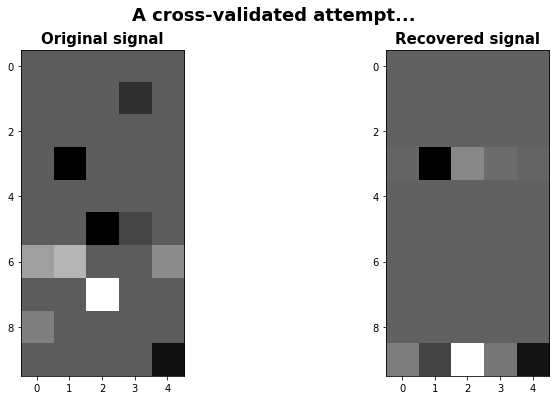

In [13]:
W_hat = regressor.weights

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_title('Original signal', fontweight="bold", fontsize=15)
axes[0].imshow(W, cmap="binary")

axes[1].set_title('Recovered signal', fontweight="bold", fontsize=15)
axes[1].imshow(W_hat, cmap="binary")

fig.suptitle('A cross-validated attempt...', fontweight="bold", fontsize=18);

- Plot support recovery / nombre d'itérations
- Plot support recovery / alpha
- Use cross-validation to select the right hyperparameter. Enhance MultiTaskLassoCV?